In [1]:
import os
import sumolib
from routing_lib import from_sumo_to_igraph_network
from meru import get_map_shape

output_folder = './drive/MyDrive/SimulationOutputs/'

os.makedirs(output_folder, exist_ok=True)
root = os.getcwd()

C:\Users\Ludovico\anaconda3\envs\Geo\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
result_dict = {}

# EXTRACTING INFO FROM THE THREE NETWORKS

for city in ['florence', 'rome', 'milan_big']:
    road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
    mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

    road_network = sumolib.net.readNet(road_network_path, withInternal=False)
    G = from_sumo_to_igraph_network(road_network)
    
    # Raw Shape of network location
    map_shape = get_map_shape(G)

    # Projecting on Italy: EPSG:3004 is centered on Italy
    area_km2 = map_shape.to_crs(epsg=3004).geometry.area.iloc[0] / 10**6
    
    result_dict[city] = (len(road_network.getNodes()), len(road_network.getEdges()), sum(G.es['length']), area_km2)

# Get RoadNetworks Info

In [3]:
import pandas as pd

df = pd.DataFrame(result_dict).T
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df[2] = df[2] / 10**3
df.columns = ('Vertices', 'Edges', 'Road Length', 'Area (KM^2)')
df['Density'] = df['Road Length'] / df['Area (KM^2)']

df.index = [x[0].upper()+x[1:].lower().replace('_big', '') for x in df.index]
df

,Vertices,Edges,Road Length,Area (KM^2),Density
Florence,6140,11804,1050.33085,113.521951,9.252227
Rome,31798,63384,6568.99448,778.359567,8.439537
Milan,24063,46488,4339.90919,496.487978,8.741217


# Combine plots and CO2 measure reductions of all MERU parameters

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_co2_meru(sorted_df, log_scale=False):

    algo = 'MERU'

    groupby_algorithm_results = sorted_df['CO2 Tons'].groupby(sorted_df['fitted_vehicles'])
    scans = np.array(groupby_algorithm_results.mean().keys()) / 1000

    mean_value = groupby_algorithm_results.mean().values
    std_deviation = groupby_algorithm_results.std().values

    scan_mean = list(zip(scans, mean_value))
    scan_mean.sort(key=lambda x: x[0])
    x, y = zip(*scan_mean)

    if log_scale:
        x_interp = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp = np.interp(x_interp, np.log(x), np.log(y))
        x_interp = np.exp(x_interp)
        y_interp = np.exp(y_interp)
    else:
        x_interp = np.linspace(min(x), max(x), num=100)
        y_interp = np.interp(x_interp, x, y)

    plt.scatter(x, y, marker='p', s = 10, color = 'black')
    plt.plot(x_interp, y_interp, label=f'{algo}: CO2 Tons Mean', color = 'black')

    scan_std = list(zip(scans, std_deviation))
    scan_std.sort(key=lambda x: x[0])
    x, y = zip(*scan_std)

    if log_scale:
        x_interp_std = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp_std = np.interp(x_interp_std, np.log(x), np.log(y))
        x_interp_std = np.exp(x_interp_std)
        y_interp_std = np.exp(y_interp_std)
    else:
        x_interp_std = np.linspace(min(x), max(x), num=100)
        y_interp_std = np.interp(x_interp_std, x, y)

    plt.fill_between(x_interp, y_interp - y_interp_std, y_interp + y_interp_std, color='gray', alpha=0.3, label=f'{algo}: CO2 Tons Std')

    if log_scale:
        plt.xscale('log')

In [5]:
# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

Reduction in CO2 (mean) (std)
florence best baseline is GR_delta02_tau02 : 	CO2 AVG = 36.56 CO2 STD = 1.58
florence use case is MERU5000 : 		CO2 AVG = 28.64 CO2 STD = 1.25
Usecase improvement	florence	21.69%
Average improvement:	florence	0.14	0.14
rome best baseline is KMD_epsilon03 : 	CO2 AVG = 117.00 CO2 STD = 2.37
rome use case is MERU30000 : 		CO2 AVG = 120.14 CO2 STD = 9.88
Usecase improvement	rome		-2.68%
Average improvement:	rome		-0.01	0.06
milan_big best baseline is KMD_epsilon03 : 	CO2 AVG = 107.39 CO2 STD = 1.60
milan_big use case is MERU15000 : 		CO2 AVG = 91.26 CO2 STD = 3.42
Usecase improvement	milan_big	15.02%
Average improvement:	milan_big	0.14	0.03


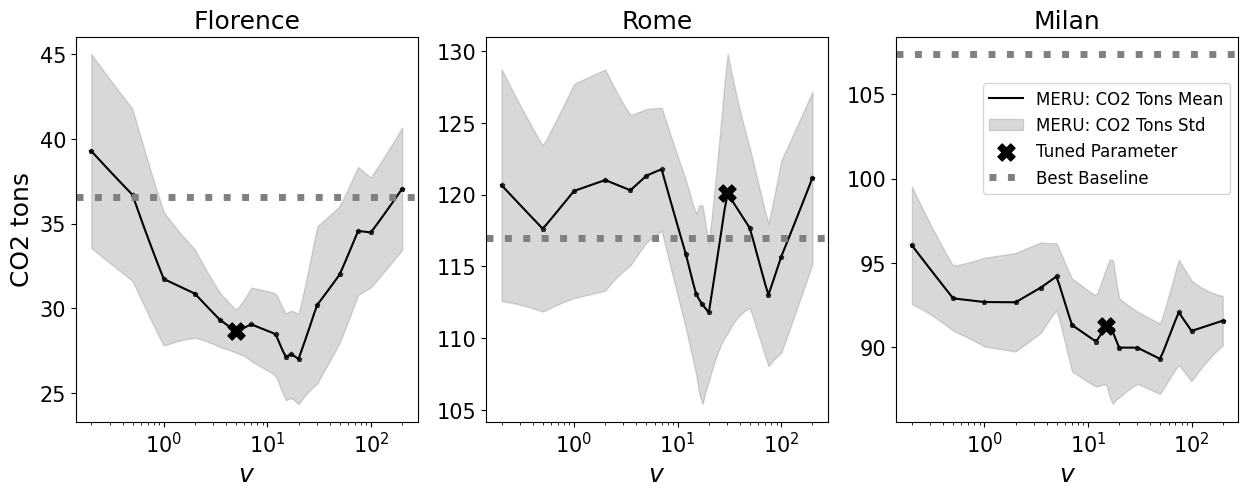

In [6]:
# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))
print('Reduction in CO2 (mean) (std)')

for n, city in enumerate(['florence', 'rome', 'milan_big']):
    plt.subplot(1, 3, n+1)  # 1 row, 3 columns, ith plot
    
    if n == 0:
        plt.ylabel('CO2 tons', fontsize = 18)
    
    log = True

    fitted_vehicles = chosen_map[city]
    
    results_dist = {}
    results_dist['measures'] = pd.read_csv(f'{output_folder}{city}/{city}_distributions_simulation_results.csv')

    df = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')
    meru_records = df['algorithm_name'].str.contains('MERU')
    seru_records = df['algorithm_name'].str.contains('SERU')
    
    without_eru = df[~meru_records & ~seru_records]
    grouped_avg = without_eru.groupby('algorithm_name')['CO2 Tons'].mean()

    # Find the value of A with the lowest average value of CO2 Tons
    best_baseline = grouped_avg.idxmin()
    
    print(city, 'best baseline is', best_baseline, end = ' : \t')
    res = df[df['algorithm_name'] == best_baseline]
    print(f"CO2 AVG = {res['CO2 Tons'].mean():.2f}",
          f"CO2 STD = {res['CO2 Tons'].std():.2f}")
    
    
    df_algo = results_dist['measures'][results_dist['measures']['algorithm_name'].str.contains('MERU')]
    df_algo['fitted_vehicles'] = df_algo['algorithm_name'].str.replace('MERU', '').astype(int)
    sorted_df = df_algo.sort_values(by=['fitted_vehicles', 'random_state'], ascending=[True, True])
    
    plot_co2_meru(sorted_df, log_scale=log)
    parameter_fitting_result_co2 = sorted_df[sorted_df['fitted_vehicles'] == fitted_vehicles]['CO2 Tons']
    
    print(city, 'use case is', f'MERU{fitted_vehicles}', end = ' : \t\t')
    print(f'CO2 AVG = {parameter_fitting_result_co2.mean():.2f}', 
          f'CO2 STD = {parameter_fitting_result_co2.std():.2f}')
    
    usecase_delta = (res['CO2 Tons'].mean() - parameter_fitting_result_co2.mean()) / res['CO2 Tons'].mean()
    print('Usecase improvement', city+'\t' if city == 'rome' else city, f'{round(usecase_delta*100, 2)}%', sep = '\t')
    
    plt.scatter([fitted_vehicles / 1000], parameter_fitting_result_co2.mean(), marker = 'X', s = 150, color = 'black', label = f'Tuned Parameter', zorder = 10)

    plt.axhline(y=res['CO2 Tons'].mean(), linewidth=5, linestyle='dotted', color='gray', label='Best Baseline')
    plt.title(f'{city[0].upper()}{city[1:].replace("_big", "")}', fontsize = 18)
    plt.xlabel('$v$', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    mean_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).mean(), 2)
    std_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).std(), 2)
    
    print('Average improvement:', city+'\t' if city == 'rome' else city, mean_x, std_x, sep = '\t')

# plt.suptitle(f'CO2 Tons w/ different parameters on cities', fontsize = 18)
# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize = 12)

# Show the plot
plt.show()


# GET EXECUTION TIME

In [17]:
from meru import MultiLevelModel, BaselineModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

attribute = 'traveltime'
random_state = 0
tests = 1000
k = 3

algorithm_parameters = {'NR' : {},
                        'KSP' : {},
                        'KD'  : {},
                        'PP'  : {'p' : 0.2},
                        'KMD' : {'epsilon' : 0.3},
                        'GR'  : {'delta' : 0.2, 'tau' : 0.2},
                        'KML' : {'theta' : 0.8},
                        'PLAT': {'epsilon' : 1.3}}

# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

In [18]:
def init_network(root, city):
    road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
    mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

    road_network = sumolib.net.readNet(road_network_path, withInternal=False)
    G = from_sumo_to_igraph_network(road_network)
    return road_network, G

def load_meru_model(G, k, attribute, random_state, fit_vehicle):
    meru = MultiLevelModel(G, k, attribute)
    meru.parameter_selection(n_vehicles = fit_vehicle, random_state = random_state)
    meru.fit(random_state = random_state)
    
    return meru

def generate_random_edges(tests, random_state):
    np.random.seed(random_state)
    seed_set = set()

    while len(seed_set) < tests:
        seed_set.add(np.random.randint(1, 999999))

    seeds = iter(seed_set)
    edges = []

    for _ in range(tests):
        np.random.seed(next(seeds))
        from_edge = np.random.choice(road_network.getEdges()).getID()
        to_edge = np.random.choice(road_network.getEdges()).getID()
        edges.append((from_edge, to_edge))
        
    return edges

def compute_algo_time(meru_model, algorithm_parameters):

    time_results = {x : [] for x in algorithm_parameters}
    time_results.update({'MERU' : [], 'SERU' : []})

    for pair in tqdm(edges):
        start = time.process_time()
        meru_result = meru_model.predict(*pair, k = k, multilevel = True)
        time_results['MERU'].append(time.process_time() - start)

        start = time.process_time()
        seru_result = meru_model.predict(*pair, k = k, multilevel = False)
        time_results['SERU'].append(time.process_time() - start)

        for key in algorithm_parameters:
            start = time.process_time()
            bm = BaselineModel(key, G, k, attribute, **algorithm_parameters[key])
            bm.predict(*pair)
            time_results[key].append(time.process_time() - start)
            
    return time_results

/home/llemma/.local/lib/python3.8/site-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 701.69it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:39<00:00,  2.98s/it]


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:10<00:00, 96.53it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [6:35:37<00:00, 23.74s/it]


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:46<00:00, 141.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:10:44<00:00, 18.64s/it]


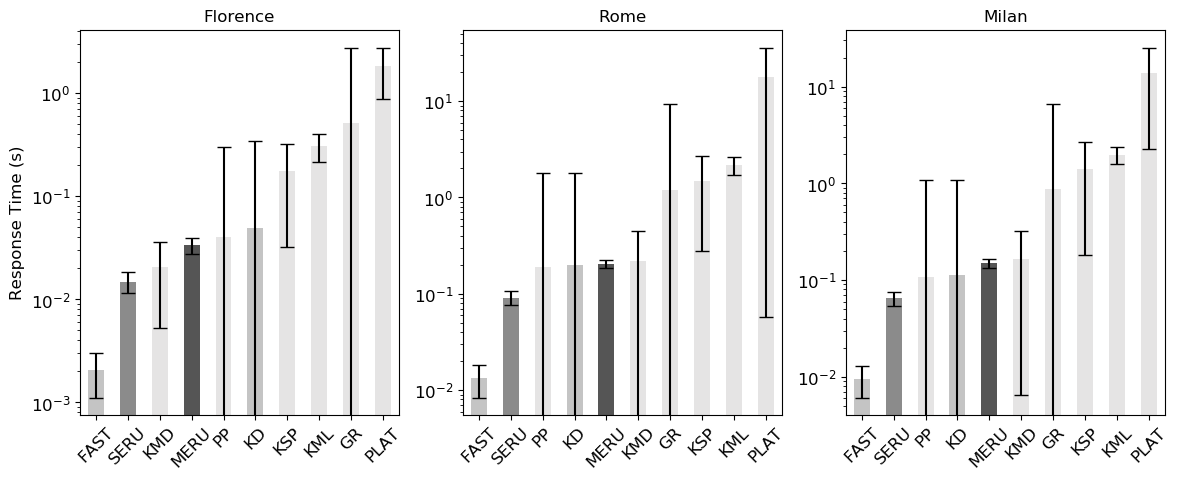

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))  # Width: 12 inches, Height: 4 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    road_network, G = init_network(root, city)
    meru_model = load_meru_model(G, k, attribute, random_state, chosen_map[city])
    
    edges = generate_random_edges(tests, random_state)
    time_results = compute_algo_time(meru_model, algorithm_parameters)
    
    ax = axes[idx]
    
    df = pd.DataFrame(time_results).mean().sort_values()

    colors_map = {}

    for x in df.index:
        if x == 'NR' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#0d0d0d'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())

    std_devs = pd.DataFrame(time_results)[df.index].std().values
    df.plot(kind = 'bar', yerr=std_devs, capsize=5, align='center', alpha=0.7, color = colors, ax = ax)


    ax.set_xticks(ax.get_xticks())
    names = list(df.index)
    names[names.index('NR')] = 'FAST'
    ax.set_xticklabels(names, fontsize = 12, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''))
    if idx == 0:
        ax.set_ylabel('Response Time (s)', fontsize = 12)

    # Log-transform the y-axis
    ax.set_yscale('log')
    
backup_axes = axes

In [228]:
from matplotlib.patches import Rectangle

bars = [list(zip([x.get_text() for x in ax.get_xticklabels()], [x.get_height() for x in ax.get_children() if type(x) is Rectangle])) for ax in axes]
bars = [np.array(x) for x in bars]

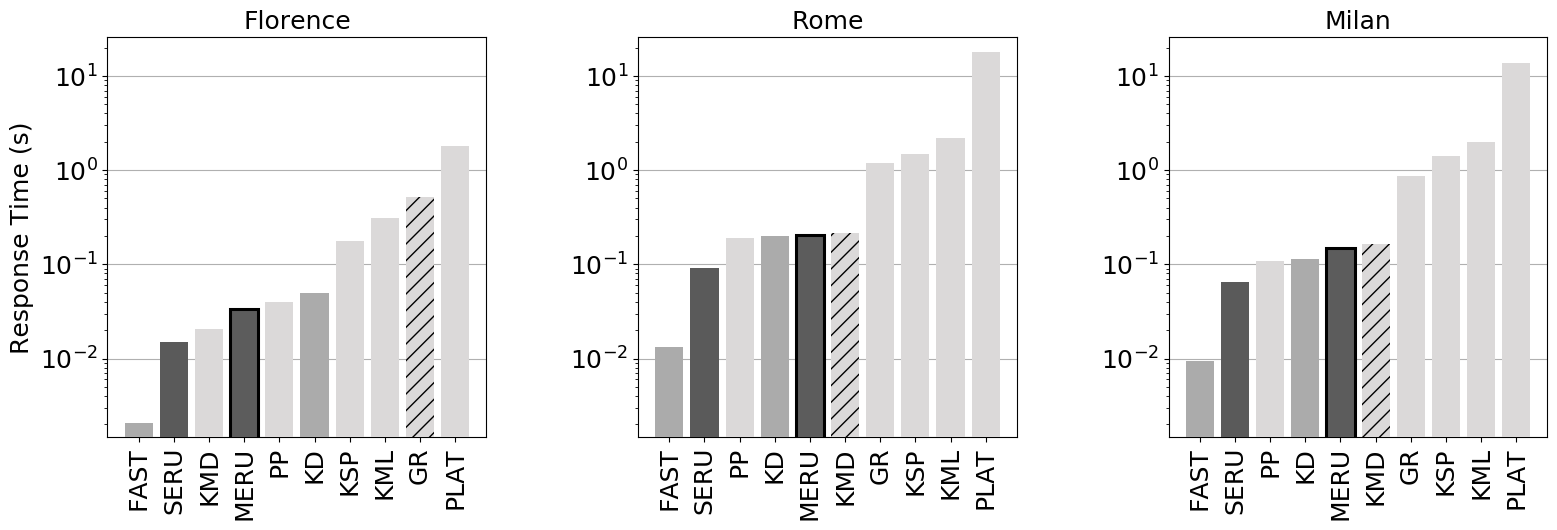

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 18 inches, Height: 5 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

best_baselines = {'florence' : 'GR', 'rome' : 'KMD', 'milan_big' : 'KMD'}
fsize = 18

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    
    ax = axes[idx]
    
    df = pd.DataFrame(bars[idx][:,1], index = bars[idx][:,0], columns = ['data'])['data'].astype(float)
    
    colors_map = {}

    for x in df.index:
        if x == 'FAST' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#5c5c5c'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())
    
    ax.bar(df.index, df.values, ecolor='black', color = colors, zorder = 100, width = 0.8)

    ax.bar(list(df.index).index('MERU'), df['MERU'], edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
    ax.bar(list(df.index).index(best_baselines[city]), df[best_baselines[city]], color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


    ax.set_xticks(ax.get_xticks())
    names = list(df.index)
    ax.set_xticklabels(names, fontsize = 12, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''))

    
    ax.grid(axis='y', which='major', zorder = 0)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)

    ax.tick_params(axis='both', which='both', labelsize=fsize)
    ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
        

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    if idx == 0:
        ax.set_ylabel('Response Time (s)', fontsize = fsize)

    # Log-transform the y-axis
    ax.set_yscale('log')

mint = min([ax.get_ylim()[0] for ax in axes])
maxt = max([ax.get_ylim()[-1] for ax in axes])
[ax.set_ylim(mint, maxt) for ax in axes]
plt.show()

# GET MEASURES

In [280]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

cols = { 'CO2 Tons': 'CO2 Tons',
         'N Teleports': 'Number of Collisions',
         'Total Redundancy': 'Total Redundancy',
         'N Traveled Edges': 'Number of Traveled Edges',
         'Avg Diversity of Suggestions': 'Average Diversity of Suggestions',
         'Road Coverage': 'Road Coverage',
         'Entropy': 'Total Entropy',
         'Vehicles Traveltime': 'Simulation Vehicles Traveltime',
         'Avg Traveled Edge Traveltime': 'Average Edge Traversal time',
         'Avg Traveled Path Traveltime': 'Average Path Travel-time'}

best_baselines = {'florence' : 'GR', 'rome' : 'KMD', 'milan_big' : 'KMD'}

['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU5000', 'NR', 'PLAT_epsilon13', 'PP_p02', 'SERU5000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU30000', 'NR', 'PLAT_epsilon13', 'PP_p02', 'SERU30000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta07', 'KSP', 'MERU15000', 'NR', 'PLAT_epsilon13', 'PP_p005', 'SERU15000']


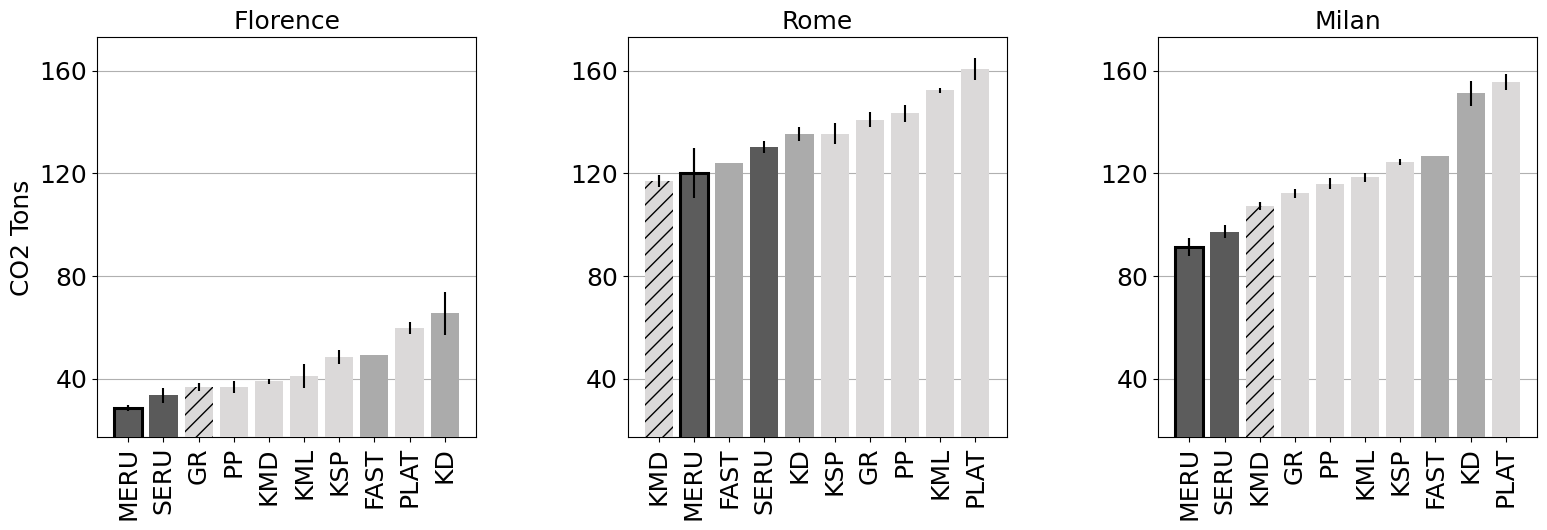

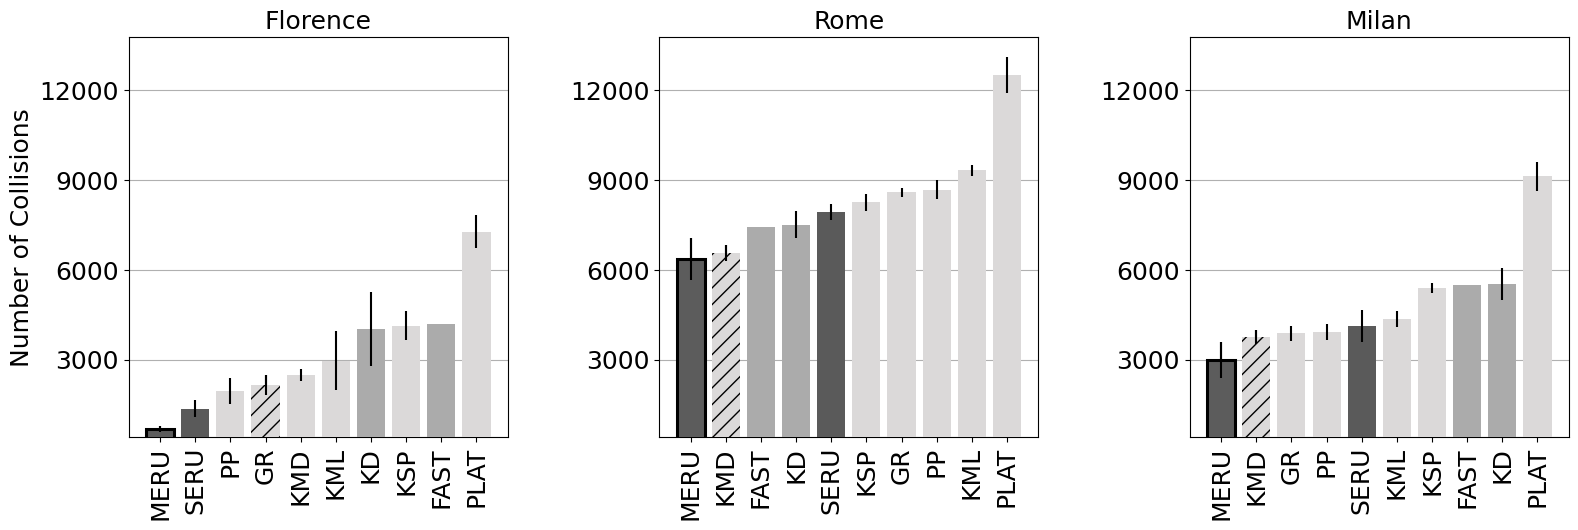

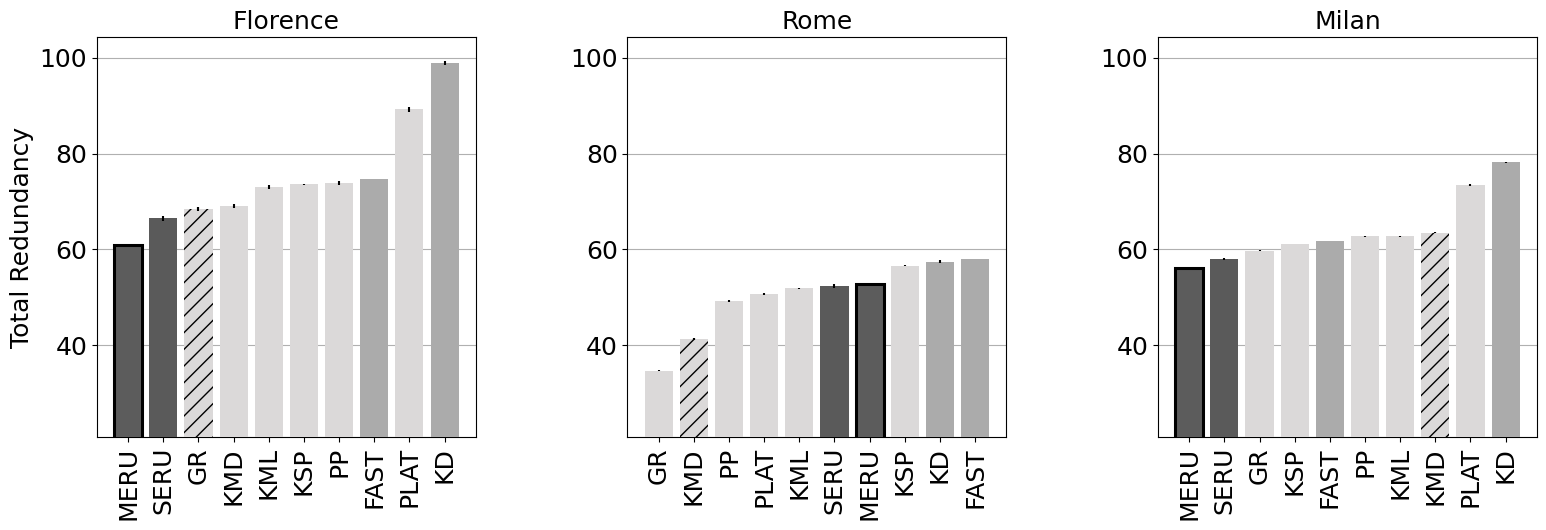

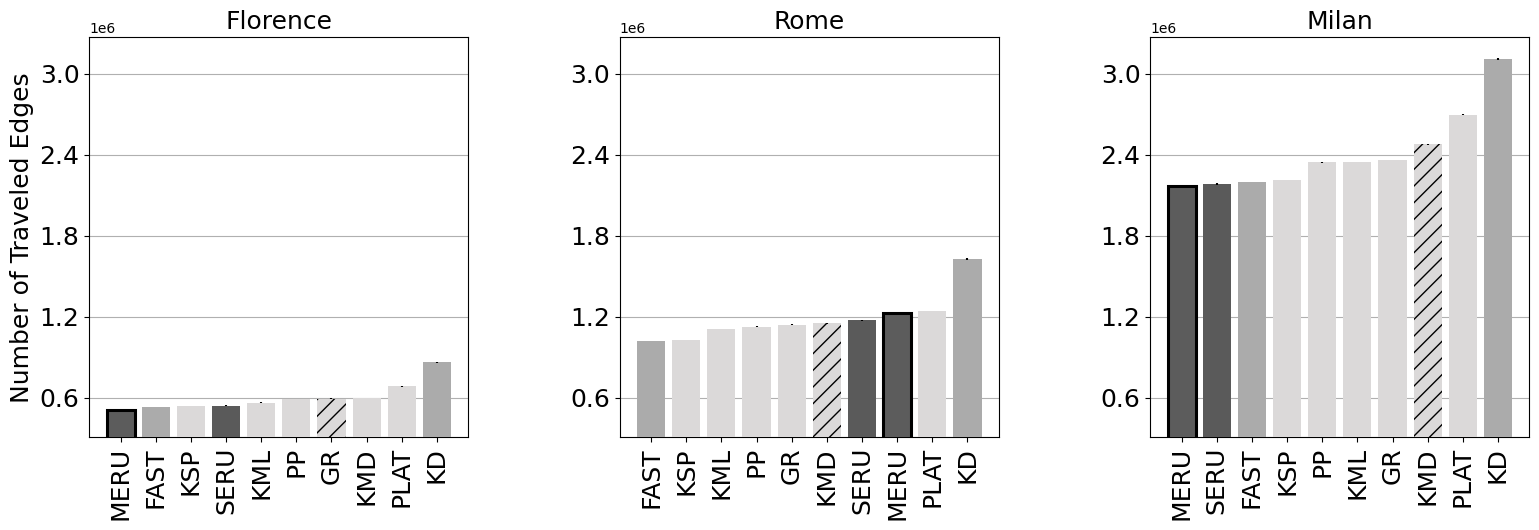

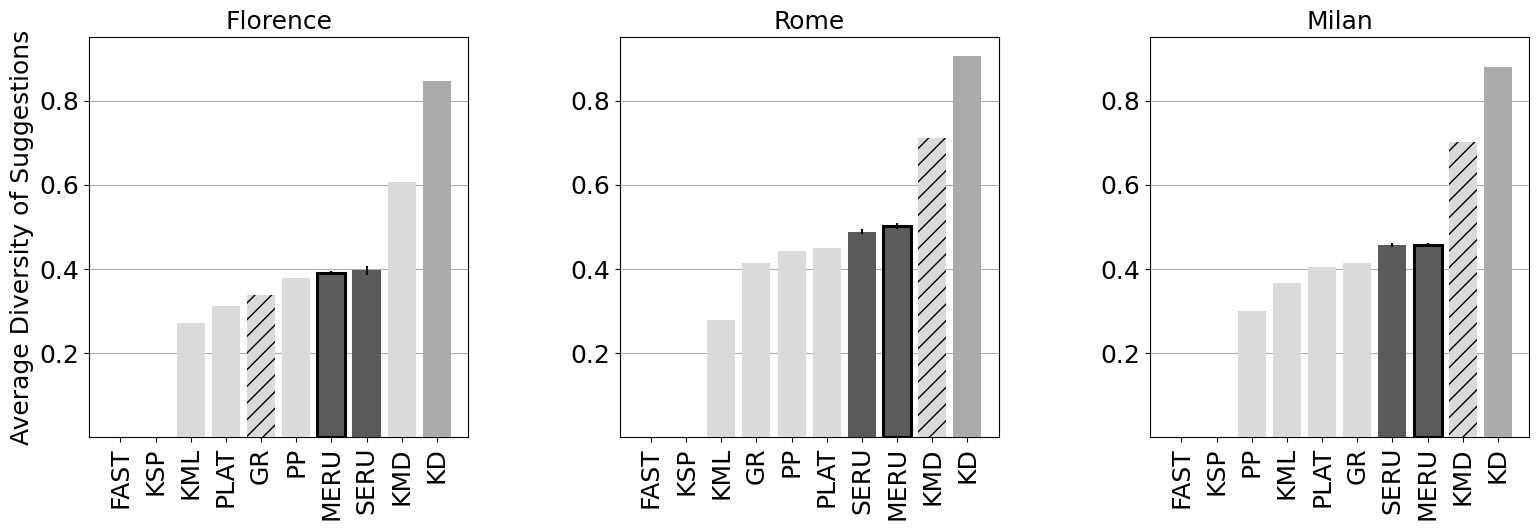

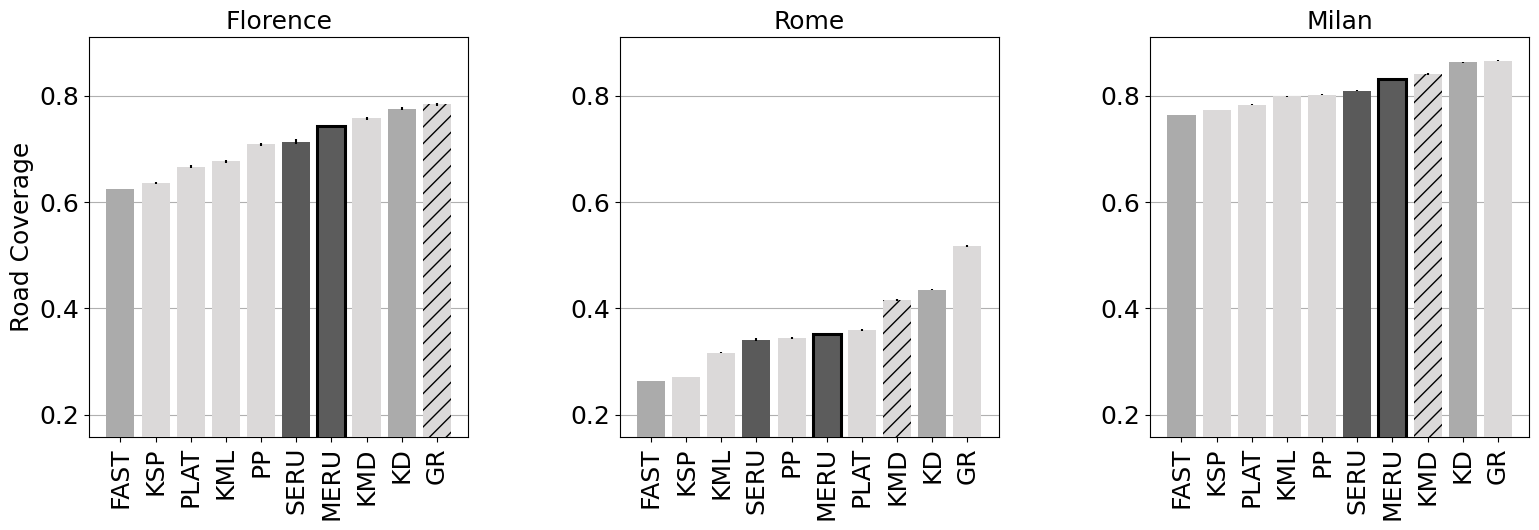

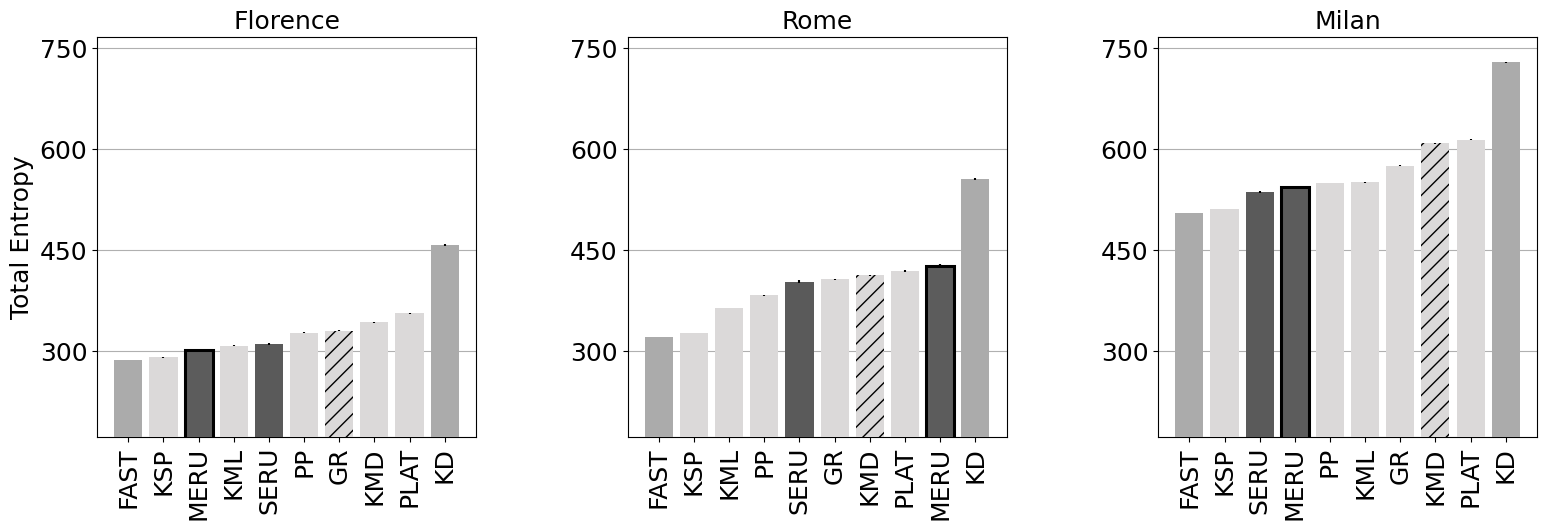

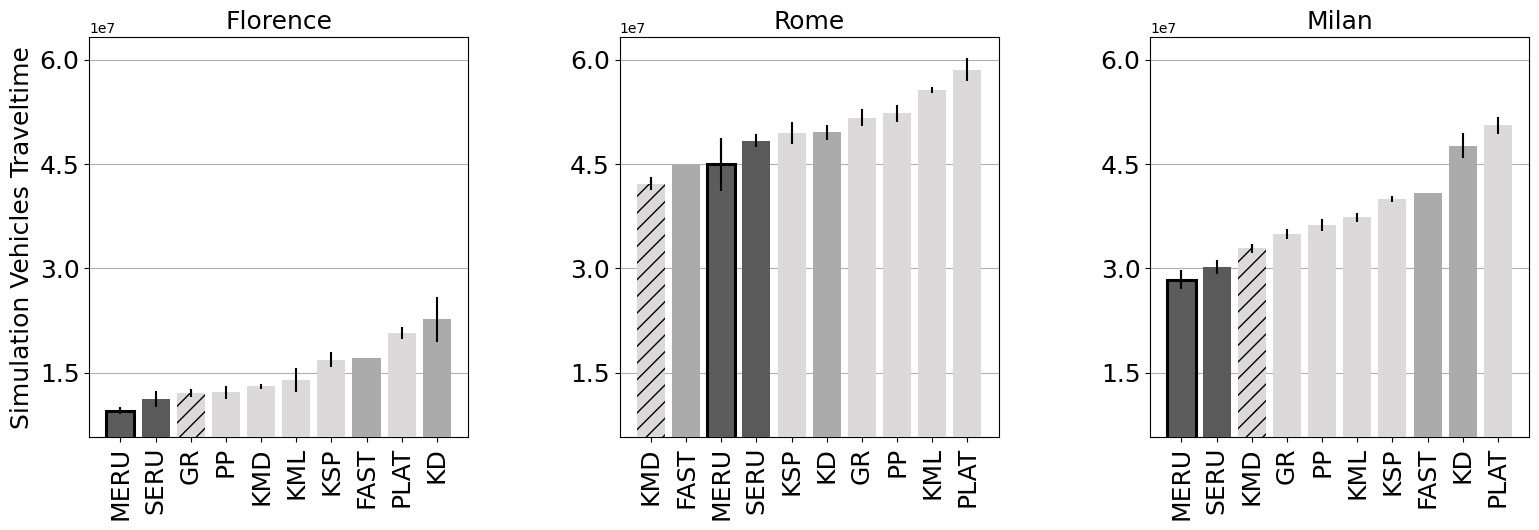

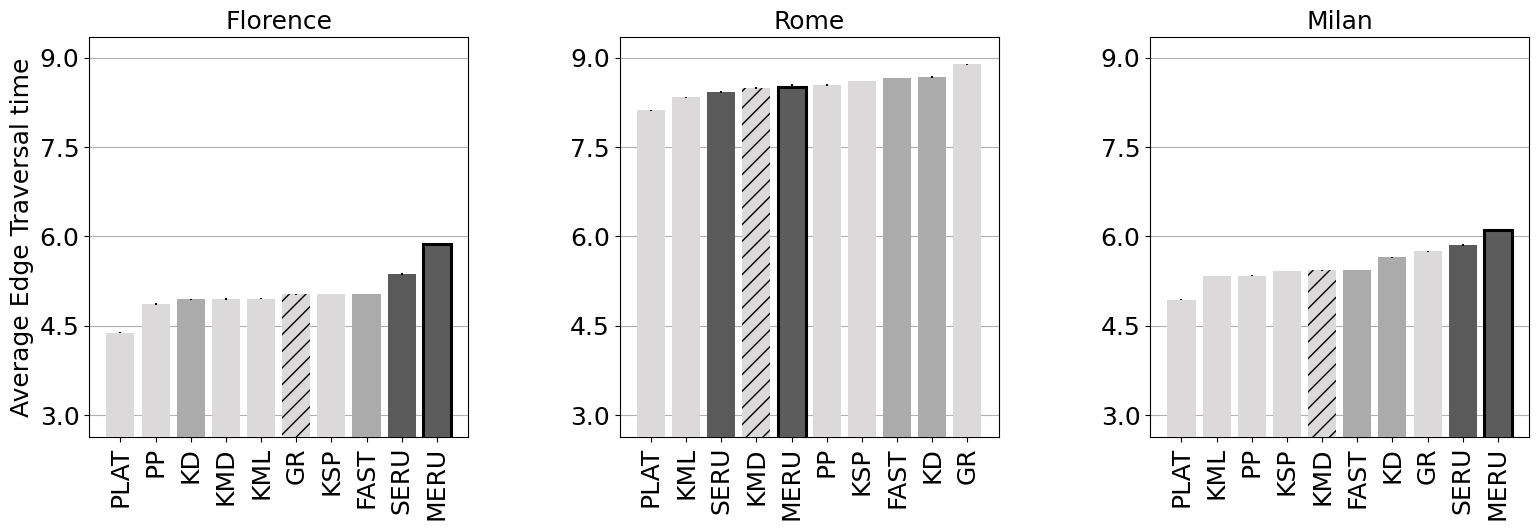

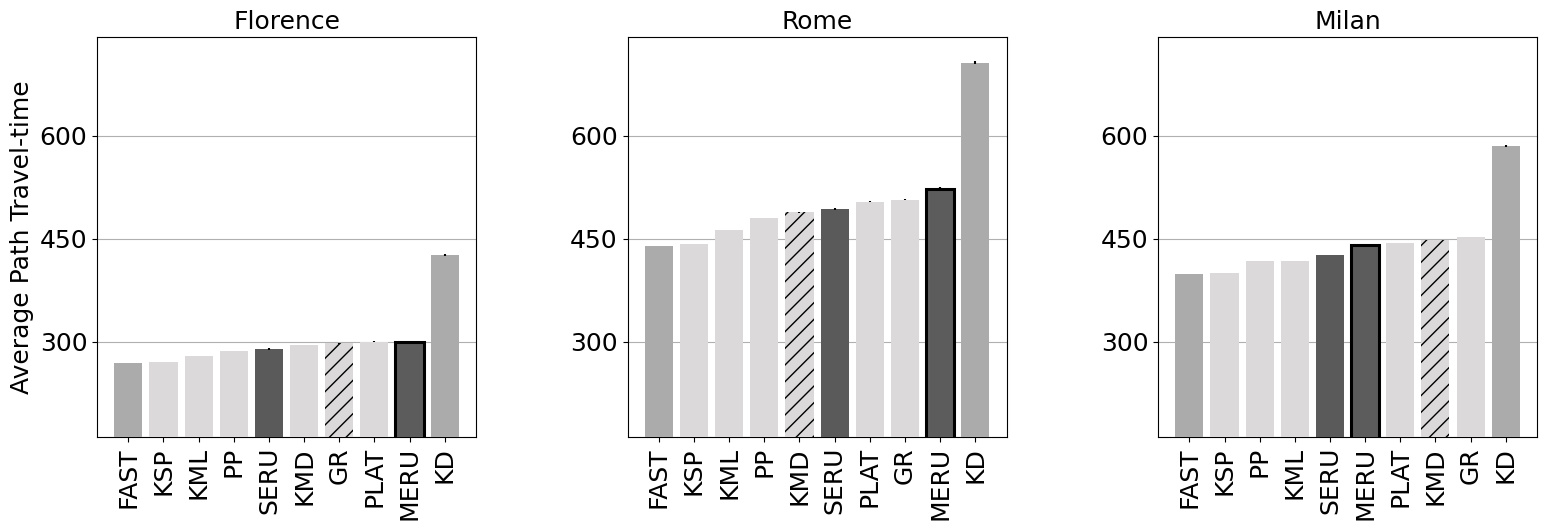

In [281]:
city_df = {k: pd.DataFrame() for k in ['florence', 'rome', 'milan_big']}

for col in cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 18 inches, Height: 5 inches
    # Flatten the axes list for easy indexing
    axes = axes.flatten()
    fsize = 18
    
    for idx, city in enumerate(['florence', 'rome', 'milan_big']):

        ax = axes[idx]

        df_source = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')

        to_plot = df_source['CO2 Tons'].groupby(df_source['algorithm_name']).mean()
        to_plot = pd.DataFrame(to_plot).reset_index()
        to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

        # Find the rows with the lowest CO2 Tons for each algorithm prefix
        result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
        # Reset index to clean up the DataFrame
        result_df = result_df.reset_index(drop=True)
        # Drop the algorithm_prefix column if you don't need it anymore
        result_df = result_df.drop(columns=['algorithm_prefix'])

        lowest_CO2_ls = result_df['algorithm_name'].tolist()
        if col == list(cols)[0]:
            print(lowest_CO2_ls)

        CO2_df = df_source[df_source['algorithm_name'].isin(lowest_CO2_ls)]

        measure_df = CO2_df.groupby('algorithm_name')[col]
        std_series = measure_df.std()
        mean_series = measure_df.mean().fillna(0)
        
        mean_series.index = [x.split('_')[0]\
                             .replace('NR', 'FAST')\
                             .replace(f'MERU{chosen_map[city]}', 'MERU')\
                             .replace(f'SERU{chosen_map[city]}', 'SERU')\
                             for x in mean_series.index]
        
        to_append = pd.DataFrame(mean_series, columns = [col])
        to_append.columns = [cols[x] for x in to_append.columns]
        city_df[city] = pd.concat((city_df[city], to_append), axis = 1)
        std_series.index = mean_series.index
        mean_series = mean_series.sort_values()

        colors_map = {}

        for x in mean_series.index:
            if x == 'FAST' or x == 'KD':
                colors_map[x] = '#ababab'
            elif 'SERU' in x:
                colors_map[x] = '#5A5A5A'
            elif 'MERU' in x:
                colors_map[x] = '#5c5c5c'
            else:
                colors_map[x] = '#dbd9d9'

        colors = list(colors_map.values())
        
        yerr = std_series.reindex(mean_series.index)
        
        #mean_series.plot(kind = 'bar', yerr = yerr, ecolor='black', capsize=5, align='center', alpha=1, color = colors, ax = ax, zorder = 100, width=0.5)
        ax.bar(mean_series.index, mean_series.values, yerr = yerr, ecolor='black', color = colors, zorder = 100, width = 0.8)
        
        ax.bar(list(mean_series.index).index('MERU'), mean_series['MERU'], yerr = yerr['MERU'], ecolor='black', edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
        ax.bar(list(mean_series.index).index(best_baselines[city]), mean_series[best_baselines[city]], yerr = yerr[best_baselines[city]], ecolor='black', color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


        ax.grid(axis='y', which='both', zorder = 0)
        ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)
        
        if idx == 0:
            ax.set_ylabel(cols[col], fontsize = fsize)
        
        ax.set_ylim(mean_series.min()*0.6)
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5))

        ax.tick_params(axis='both', which='both', labelsize=fsize)
        ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
        
    mint = min([ax.get_ylim()[0] for ax in axes])
    maxt = max([ax.get_ylim()[-1] for ax in axes])
    [ax.set_ylim(mint, maxt) for ax in axes]
    [ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5)) for ax in axes]


    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    plt.show()

# NORMALIZED ENTROPY

['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU5000', 'NR', 'PLAT_epsilon13', 'PP_p02', 'SERU5000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU30000', 'NR', 'PLAT_epsilon13', 'PP_p02', 'SERU30000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta07', 'KSP', 'MERU15000', 'NR', 'PLAT_epsilon13', 'PP_p005', 'SERU15000']


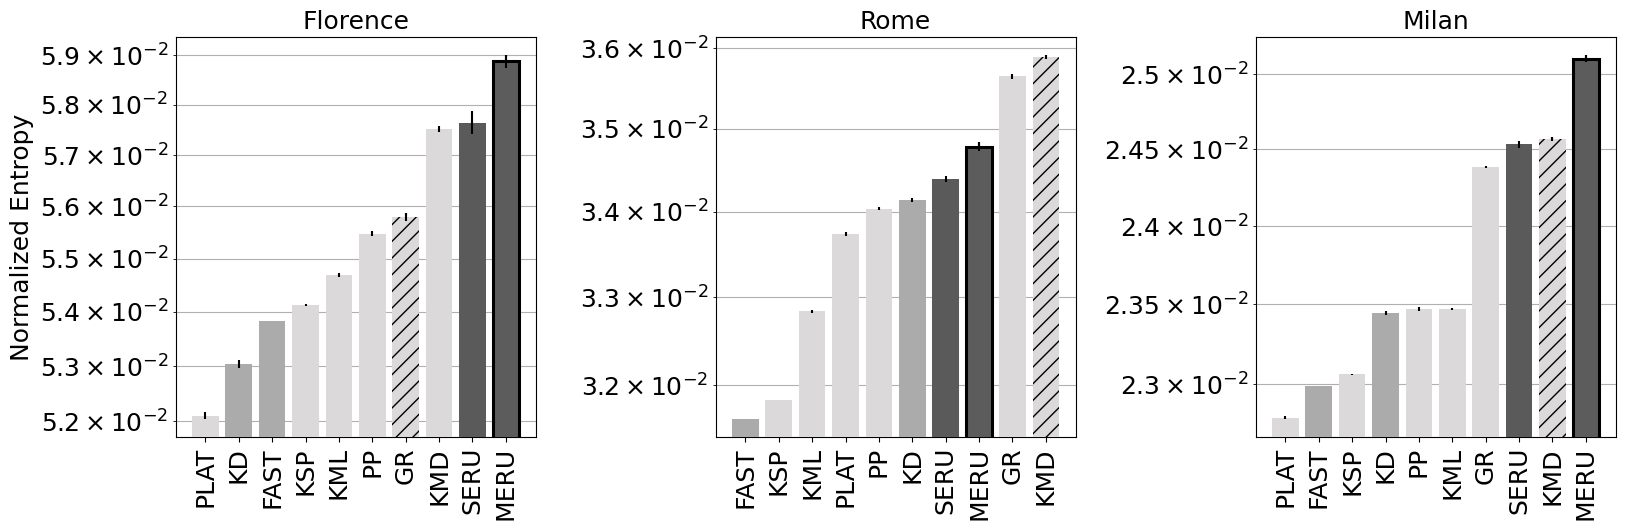

In [282]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 12 inches, Height: 4 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    
    ax = axes[idx]
    
    df_source = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')

    to_plot = df_source['CO2 Tons'].groupby(df_source['algorithm_name']).mean()
    to_plot = pd.DataFrame(to_plot).reset_index()
    to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

    # Find the rows with the lowest CO2 Tons for each algorithm prefix
    result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
    # Reset index to clean up the DataFrame
    result_df = result_df.reset_index(drop=True)
    # Drop the algorithm_prefix column if you don't need it anymore
    result_df = result_df.drop(columns=['algorithm_prefix'])

    lowest_CO2_ls = result_df['algorithm_name'].tolist()
    print(lowest_CO2_ls)
    
    CO2_df = pd.DataFrame(df_source[df_source['algorithm_name'].isin(lowest_CO2_ls)])
    CO2_df['Normalized Entropy'] = CO2_df['Entropy'] / CO2_df['N Traveled Edges'] * 100
    
    measure_df = CO2_df.groupby('algorithm_name')['Normalized Entropy']
    std_series = measure_df.std()
    mean_series = measure_df.mean().fillna(0)
    mean_series.index = [x.split('_')[0]\
                         .replace('NR', 'FAST')\
                         .replace(f'MERU{chosen_map[city]}', 'MERU')\
                         .replace(f'SERU{chosen_map[city]}', 'SERU')\
                         for x in mean_series.index]
    
    city_df[city] = pd.concat((city_df[city], mean_series), axis = 1)

    std_series.index = mean_series.index
    mean_series = mean_series.sort_values()

    colors_map = {}

    for x in mean_series.index:
        if x == 'FAST' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#5c5c5c'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())

    yerr = std_series.reindex(mean_series.index)

    #mean_series.plot(kind = 'bar', yerr = yerr, ecolor='black', capsize=5, align='center', alpha=1, color = colors, ax = ax, zorder = 100, width=0.5)
    ax.bar(mean_series.index, mean_series.values, yerr = yerr, ecolor='black', color = colors, zorder = 100, width = 0.8)

    ax.bar(list(mean_series.index).index('MERU'), mean_series['MERU'], yerr = yerr['MERU'], ecolor='black', edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
    ax.bar(list(mean_series.index).index(best_baselines[city]), mean_series[best_baselines[city]], yerr = yerr[best_baselines[city]], ecolor='black', color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


    ax.grid(axis='y', which='both', zorder = 0)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)

    if idx == 0:
        ax.set_ylabel('Normalized Entropy', fontsize = fsize)

    ax.tick_params(axis='both', which='both', labelsize=fsize)
    ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
    
    ax.set_yscale('log')


plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)

plt.show()

# POPULARITY AND TYPE OF CROSSINGS

In [283]:
def clean_counter(x):
    return x.replace('Counter({', '{').replace('})', '}')

def decounter_column(series):
    return series.astype(str).apply(clean_counter).apply(eval)

colors_map = {}

for x in df_source['algorithm_name']:
    if x == 'NR' or x == 'KD':
        colors_map[x] = '#ababab'
    elif 'SERU' in x:
        colors_map[x] = '#5A5A5A'
    elif 'MERU' in x:
        colors_map[x] = '#0d0d0d'
    else:
        colors_map[x] = '#dbd9d9'

chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}


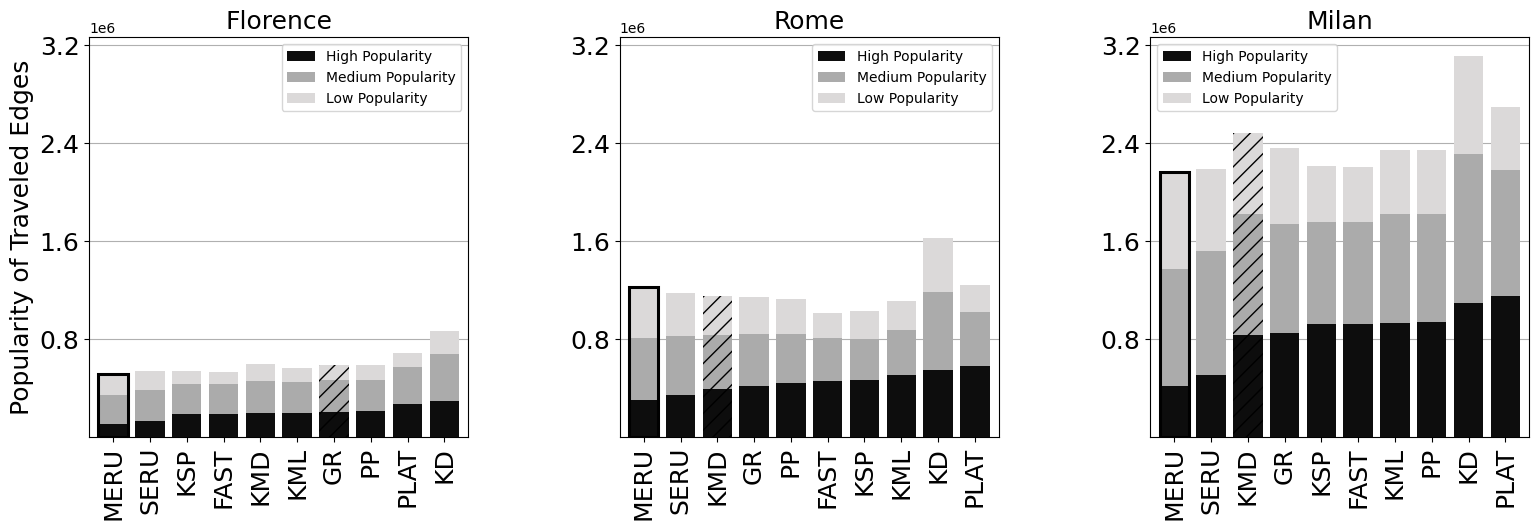

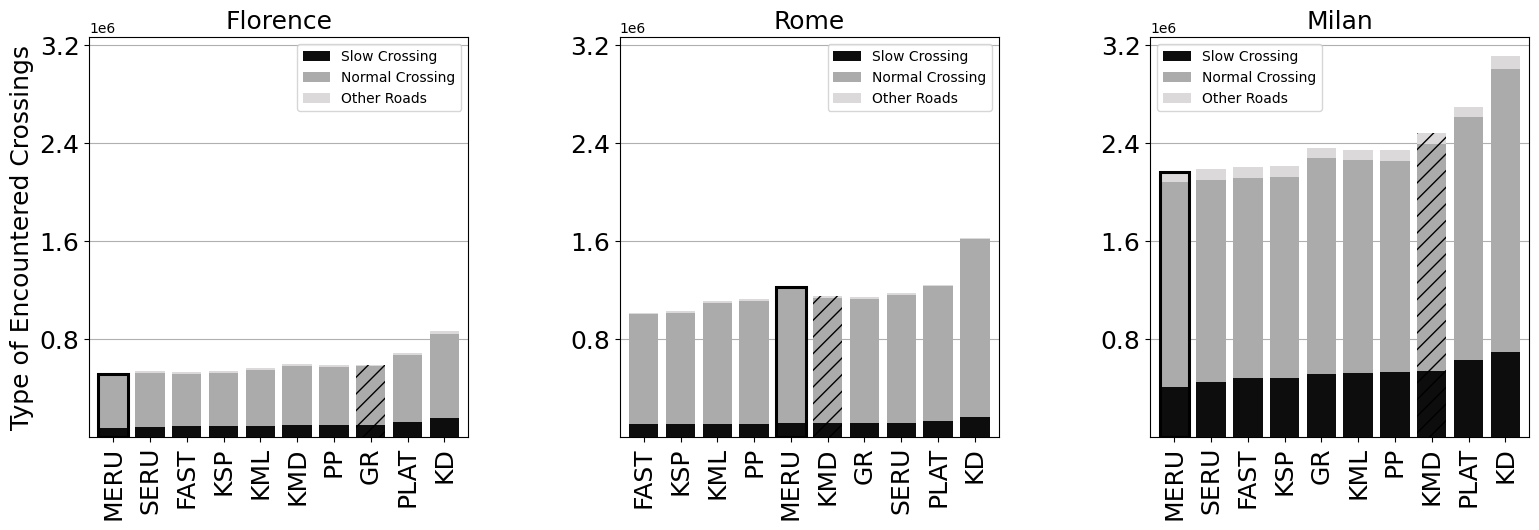

In [284]:
cols = {'Traveled Popularity': 'Popularity of Traveled Edges',
         'Traveled Crossings': 'Type of Encountered Crossings'}

special_cols = {'Popularity of Traveled Edges' : ['H', 'M', 'L'], 'Type of Encountered Crossings' : ['slow_crossing', 'normal_crossing', 'not_crossing']}
map_special_cols = {'Popularity of Traveled Edges' : {'H' : 'High Popularity', 'M' : 'Medium Popularity', 'L' : 'Low Popularity'}, 
                    'Type of Encountered Crossings' : {'slow_crossing' : 'Slow Crossing', 'normal_crossing' : 'Normal Crossing', 'not_crossing' : 'Other Roads'}}

for col in cols:
    
    measure = cols[col]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 18 inches, Height: 5 inches
    # Flatten the axes list for easy indexing
    axes = axes.flatten()
    fsize = 18
    
    for idx, city in enumerate(['florence', 'rome', 'milan_big']):
        
        ax = axes[idx]

        df_source = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')

        to_plot = df_source['CO2 Tons'].groupby(df_source['algorithm_name']).mean()
        to_plot = pd.DataFrame(to_plot).reset_index()
        to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

        # Find the rows with the lowest CO2 Tons for each algorithm prefix
        result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
        # Reset index to clean up the DataFrame
        result_df = result_df.reset_index(drop=True)
        # Drop the algorithm_prefix column if you don't need it anymore
        result_df = result_df.drop(columns=['algorithm_prefix'])

        lowest_CO2_ls = result_df['algorithm_name'].tolist()

        CO2_df = df_source[df_source['algorithm_name'].isin(lowest_CO2_ls)][col]
        
        temp_df = pd.DataFrame(decounter_column(CO2_df))

        # Initialize an empty DataFrame to hold the extracted values
        extracted_df = pd.DataFrame()
        
        for index, row in temp_df.iterrows():
            extracted_df = pd.concat((extracted_df, pd.DataFrame(row[col], index = np.arange(1))), ignore_index=True)
        extracted_df = extracted_df[special_cols[measure]]
        extracted_df['algorithm_name'] = df_source.loc[CO2_df.index]['algorithm_name'].values
        measure_df = extracted_df.groupby('algorithm_name')
        mean_series = measure_df.mean().fillna(0)
        mean_series.index = [x.split('_')[0]\
                             .replace('NR', 'FAST')\
                             .replace(f'MERU{chosen_map[city]}', 'MERU')\
                             .replace(f'SERU{chosen_map[city]}', 'SERU')\
                             for x in mean_series.index]

        to_plot = mean_series.sort_values(by = special_cols[measure])
        to_plot.columns = list(map(lambda x: map_special_cols[measure][x], to_plot.columns))
        
        to_plot.plot(kind='bar', stacked=True, ax=ax, color = ['#0d0d0d', '#ababab', '#dbd9d9'], zorder = 100, width = 0.8)
        ax.bar(list(to_plot.index).index('MERU'), to_plot.loc['MERU'].sum(), edgecolor='black', color = (0.08, 0.08, 0.08, 0), linewidth=2.2, zorder = 200, width = 0.8)
        ax.bar(list(to_plot.index).index(best_baselines[city]), to_plot.loc[best_baselines[city]].sum(), hatch = '//', color = (0.08, 0.08, 0.08, 0), linewidth=2.2, zorder = 200, width = 0.8)
        
        ax.grid(axis='y', which='both', zorder = 0)
        ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)
        
        if idx == 0:
            ax.set_ylabel(cols[col], fontsize = fsize)
        
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5))

        ax.tick_params(axis='both', which='both', labelsize=fsize)
        ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
        
        city_df[city] = pd.concat((city_df[city], to_plot), axis = 1)
        
    mint = min([ax.get_ylim()[0] for ax in axes])
    maxt = max([ax.get_ylim()[-1] for ax in axes])
    [ax.set_ylim(mint, maxt) for ax in axes]
    [ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5)) for ax in axes]


    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    plt.show()

# SUMMARY OF MOST IMPORTANT MEASURES

In [285]:
cols_to_consider = ['CO2 Tons', 'High Popularity','Slow Crossing', 'Total Redundancy', 'Normalized Entropy', 'Number of Traveled Edges']
sorted_indexes = ['FAST', 'KSP', 'KD', 'PP', 'GR', 'KMD', 'PLAT', 'KML', 'SERU', 'MERU']

In [286]:
df = pd.DataFrame()
for city, dataframe in city_df.items():
    add_df = dataframe[cols_to_consider].loc[sorted_indexes]
    add_df['city'] = city[0].upper()+city[1:].replace('_big', '')
    df = pd.concat((df, add_df))
    
df.index = list(zip(df['city'].values, df.index.values))
df.drop('city', axis=1, inplace=True)

# Create a MultiIndex
multi_index = pd.MultiIndex.from_tuples(df.index, names=['', ''])

# Create a DataFrame with the MultiIndex
df = pd.DataFrame(df, index=multi_index)

In [287]:
df['Total Redundancy'] = (df['Total Redundancy']).apply(lambda x: round(x, 2))
df['Normalized Entropy'] = (df['Normalized Entropy']).apply(lambda x: round(x, 4))
df['High Popularity'] = (df['High Popularity'] / df['Number of Traveled Edges'] * 100).apply(lambda x: round(x, 2))
df['Slow Crossing'] = (df['Slow Crossing'] / df['Number of Traveled Edges'] * 100).apply(lambda x: round(x, 2))
df['CO2 Tons'] = df['CO2 Tons'].apply(lambda x: round(x, 2))

In [288]:
df.drop('Number of Traveled Edges', axis = 1)

CO2 Tons  High Popularity  Slow Crossing  Total Redundancy  \
                                                                            
Florence FAST     49.02            35.15          16.61             74.73   
         KSP      48.44            34.88          16.51             73.62   
         KD       65.46            34.54          17.99             98.90   
         PP       36.78            35.93          16.72             73.82   
         GR       36.56            34.97          17.20             68.37   
         KMD      38.97            32.37          16.01             69.00   
         PLAT     59.66            39.17          17.52             89.23   
         KML      40.98            34.80          16.28             73.06   
         SERU     33.51            25.03          14.80             66.48   
         MERU     28.64            20.97          13.80             60.85   
Rome     FAST    124.14            45.32          10.37             58.11   
         KSP     135.46            45.64          10.31             56.65   
         KD      135.39            33.57           9.95             57.49   
         PP      143.44            39.40           9.88             49.30   
         GR      140.98            36.78          10.00             34.75   
         KMD     117.00            34.42           9.87             41.34   
         PLAT    160.57            47.02          10.66             50.79   
         KML     152.40            45.99           9.95             51.90   
         SERU    130.25            29.27           9.92             52.39   
         MERU    120.14            24.68           9.14             52.71   
Milan    FAST    126.61            41.96          22.05             61.75   
         KSP     124.36            41.65          21.95             61.15   
         KD      151.18            35.22          22.32             78.16   
         PP      115.96            40.10          22.68             62.76   
         GR      112.28            35.86          21.86             59.71   
         KMD     107.39            33.77          21.92             63.52   
         PLAT    155.60            42.62          23.32             73.44   
         KML     118.48            39.76          22.15             62.78   
         SERU     97.22            23.17          20.67             57.99   
         MERU     91.26            19.19          19.05             56.14   

               Normalized Entropy  
                                   
Florence FAST              0.0538  
         KSP               0.0541  
         KD                0.0530  
         PP                0.0555  
         GR                0.0558  
         KMD               0.0575  
         PLAT              0.0521  
         KML               0.0547  
         SERU              0.0576  
         MERU              0.0589  
Rome     FAST              0.0316  
         KSP               0.0318  
         KD                0.0341  
         PP                0.0340  
         GR                0.0356  
         KMD               0.0359  
         PLAT              0.0337  
         KML               0.0328  
         SERU              0.0344  
         MERU              0.0348  
Milan    FAST              0.0230  
         KSP               0.0231  
         KD                0.0234  
         PP                0.0235  
         GR                0.0244  
         KMD               0.0246  
         PLAT              0.0228  
         KML               0.0235  
         SERU              0.0245  
         MERU              0.0251

# PLOTTING ALTERNATIVES

In [290]:
city = 'florence'

road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

road_network = sumolib.net.readNet(road_network_path, withInternal=False)
G = from_sumo_to_igraph_network(road_network)

# Raw Shape of network location
map_shape = get_map_shape(G)

city_center = map_shape.centroid[0].coords[0]

C:\Users\Ludovico\AppData\Local\Temp\ipykernel_6304\479713767.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = map_shape.centroid[0].coords[0]


In [291]:
from meru.multilevel import MultiLevelModel

k = 3
attribute = 'traveltime'
random_state = 42
distributions_to_test = [200, 500, 1000, 2000, 3500, 5000, 7000, 12000, 15000, 
                         17000, 20000, 30000, 50000, 75000, 100000, 200000]

# I wrote here for clarity what are basically default parameters
params = {'default_vehicles' : 3500, # if it fails it gives this n° of vehicles
          'tuning_parameters' : distributions_to_test}
meru_model = MultiLevelModel(G, k, attribute, params = params)

print('Performing parameter selection!')

# If you apply a balance threshold of 1 it will fail to find the correct parameter
# I am doing it to show the distributions of all the parameters
meru_model.parameter_selection(verbose = True, random_state = random_state)
meru_model.fit(random_state = random_state)

C:\Users\Ludovico\anaconda3\envs\Geo\lib\site-packages\skmob\tessellation\tilers.py:732: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


Performing parameter selection!
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 583.35it/s]
Parameter Selected: 5000
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 625.50it/s]


In [292]:
print('Fitting SERU!')
seru_model = MultiLevelModel(G, 1, attribute) # 1 because I need only one Klevel since a simple solution is applied
seru_model.parameter_selection(n_vehicles = meru_model.fitted_vehicles)
seru_model.fit(random_state = random_state)

Fitting SERU!
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 586.57it/s]


In [296]:
import numpy as np
np.random.seed(42)
from_edge = str(np.random.choice(G.es['id']))
to_edge = str(np.random.choice(G.es['id']))

In [297]:
from routing_lib import visualize_paths
def visualize_path_wrapper(paths, road_network, **kwargs):
    paths = [p['edges'] for p in paths]
    return visualize_paths(paths, road_network, **kwargs)

# PLOTTING TRAFFIC ASSIGNMENT

In [299]:
from meru import BaselineModel

algos = {'NR' : {}, 'KSP' : {}, 'KD': {}, 
         'PP' : {'p' : 0.2}, 'GR' : {'delta': 0.2, 'tau' : 0.2}, 'KMD' : {'epsilon' : 0.3},
         'PLAT' : {'epsilon': 1.3}, 'KML' : {'theta' : 0.8}, 
         'SERU' : {}, 'MERU' : {}}

#from routing_lib.routing_utils import visualize_paths

opacity = 0.5

for algo in algos:
    if algo == 'MERU':
        paths = meru_model.predict(from_edge, to_edge)
    elif algo == 'SERU':
        paths = seru_model.predict(from_edge, to_edge, k = 3)
    else:
        paths = BaselineModel(algo, G, 3, attribute, **algos[algo]).predict(from_edge, to_edge)
    cols = ['black', 'red', 'blue'][:len(paths)]
    m = visualize_path_wrapper(paths, road_network, opacity = opacity, colors = cols)
    m.save(f'{algo}.html')

In [300]:
import json

with open(mobility_demand_path, 'r') as f:
    mobility_demand = json.loads(f.read())

# Get unique paths to predict (same OD pair)
od_set = sorted({tuple(mobility_demand[v]['edges']) for v in mobility_demand})

In [301]:
np.random.seed(42)
sample_md = set()
sample_size = 100

while len(sample_md) < sample_size:
    idx = np.random.choice(range(len(od_set)))
    sample_md.add(od_set[idx])

In [477]:
#from routing_lib.routing_utils import visualize_paths
import folium

results = {algo : [] for algo in algos}
opacity = 0.3

for algo in algos:
        
    # Create a Folium map centered at the given coordinates
    m = folium.Map(location=list(reversed(city_center)), zoom_start=13, tiles='cartodbpositron')
    
    np.random.seed(42)
    
    if results[algo] == []:
        paths = []

        for from_edge, to_edge in tqdm(sample_md):
            if algo == 'MERU':
                suggestions = meru_model.predict(from_edge, to_edge)
            elif algo == 'SERU':
                suggestions = seru_model.predict(from_edge, to_edge, k = 3)
            else:
                suggestions = BaselineModel(algo, G, 3, attribute, **algos[algo]).predict(from_edge, to_edge)
            idx = np.random.choice(range(len(suggestions)))
            paths.append(suggestions[idx]['edges'])

        results[algo] = paths
    else:
        paths = results[algo]
        
    visualize_paths(paths, road_network, map_f = m, opacity = opacity, colors = 'black')
    m.save(f'TRAFFIC_{algo}.html')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.07it/s]
